# EDSR

In [1]:
import os
import matplotlib.pyplot as plt

from data import Thermal
from model.edsr import edsr
from train import EdsrTrainer

%matplotlib inline

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
# Number of residual blocks
depth = 16

# Super-resolution factor
scale = 4

# Downgrade operator
downgrade = 'bicubic'

In [3]:
# Location of model weights (needed for demo)
weights_dir = f'weights/edsr-{depth}-x{scale}'
weights_file = os.path.join(weights_dir, 'weights.h5')

os.makedirs(weights_dir, exist_ok=True)

## Datasets

You don't need to download the DIV2K dataset as the required parts are automatically downloaded by the `DIV2K` class. By default, DIV2K images are stored in folder `.div2k` in the project's root directory.

In [4]:
Thermal_train = Thermal(scale=4, subset='train', downgrade='bicubic')
Thermal_valid =Thermal(scale=4, subset='valid', downgrade='bicubic')

In [5]:
train_ds = Thermal_train.dataset(batch_size=1, random_transform=True)
valid_ds = Thermal_valid.dataset(batch_size=1, random_transform=True, repeat_count=1)

LR_Image Directory:
can_edge_data/Thermal_train_LR_bicubic/X4
HR_Image Directory:
can_edge_data/Thermal_train_HR
LR_Image Directory:
can_edge_data/Thermal_valid_LR_bicubic/X4
HR_Image Directory:
can_edge_data/Thermal_valid_HR


## Training

### Pre-trained models

If you want to skip training and directly run the demo below, download [weights-edsr-16-x4.tar.gz](https://martin-krasser.de/sisr/weights-edsr-16-x4.tar.gz) and extract the archive in the project's root directory. This will create a `weights/edsr-16-x4` directory containing the weights of the pre-trained model.

In [14]:
trainer = EdsrTrainer(model=edsr(scale=scale, num_res_blocks=depth), 
                      checkpoint_dir=f'.ckpt/edsr-{depth}-x{scale}')

In [15]:
# Train EDSR model for 300,000 steps and evaluate model
# every 1000 steps on the first 10 images of the DIV2K
# validation set. Save a checkpoint only if evaluation
# PSNR has improved.
trainer.train(train_ds,
              valid_ds.take(10),
              steps=300000, 
              evaluate_every=1000, 
              save_best_only=True)

1000/300000: loss = 5.832, PSNR = 37.410286 (35.88s)
2000/300000: loss = 2.563, PSNR = 40.233833 (31.02s)
3000/300000: loss = 1.586, PSNR = 43.006184 (30.79s)
4000/300000: loss = 1.529, PSNR = 37.281502 (30.69s)
5000/300000: loss = 1.166, PSNR = 40.509594 (30.63s)
6000/300000: loss = 0.619, PSNR = 41.571148 (30.99s)
7000/300000: loss = 0.721, PSNR = 40.635948 (30.74s)
8000/300000: loss = 0.604, PSNR = 42.425556 (30.85s)
9000/300000: loss = 1.542, PSNR = 39.529591 (30.77s)
10000/300000: loss = 1.657, PSNR = 43.744770 (31.20s)
11000/300000: loss = 1.160, PSNR = 43.688427 (31.02s)
12000/300000: loss = 1.220, PSNR = 36.570103 (30.70s)
13000/300000: loss = 0.926, PSNR = 42.463238 (31.02s)
14000/300000: loss = 0.598, PSNR = 44.282032 (30.71s)
15000/300000: loss = 0.667, PSNR = 45.101254 (30.77s)
16000/300000: loss = 0.558, PSNR = 43.273403 (30.72s)
17000/300000: loss = 1.382, PSNR = 43.407990 (30.84s)
18000/300000: loss = 1.527, PSNR = 38.934692 (30.66s)
19000/300000: loss = 1.056, PSNR = 42

In [16]:
# Restore from checkpoint with highest PSNR
trainer.restore()

Model restored from checkpoint at step 252000.


In [17]:
# Evaluate model on full validation set
psnrv = trainer.evaluate(valid_ds)
print(f'PSNR = {psnrv.numpy():3f}')

PSNR = 40.906521


In [18]:
# Save weights to separate location (needed for demo)
trainer.model.save_weights(weights_file)

## Demo

In [7]:
model = edsr(scale=scale, num_res_blocks=depth)
model.load_weights(weights_file)

In [8]:
from model import resolve_single
from utils import load_image, plot_sample
import cv2
import numpy as np
import tensorflow as tf
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
import cv2

def resolve_and_plot(lr_image_path, hr_image_path):
    lr = load_image(lr_image_path)
    lr = cv2.cvtColor(lr, cv2.COLOR_GRAY2BGR)
    hr = load_image(hr_image_path)
    sr = resolve_single(model, lr)
    #print(hr.shape)
    #print(sr.shape)    
    plot_sample(lr, sr, hr)
    mse = tf.keras.losses.MeanSquaredError()
    sr2 = cv2.cvtColor(np.float32(sr), cv2.COLOR_BGR2GRAY)
    ssim_e = ssim(sr2, hr, data_range=hr.max() - hr.min())
    print(ssim_e)
    #err = mse(hr, sr2).numpy()
    #print("The mean square error of the two images is:")
    #print(err)
    

0.9846953943515921


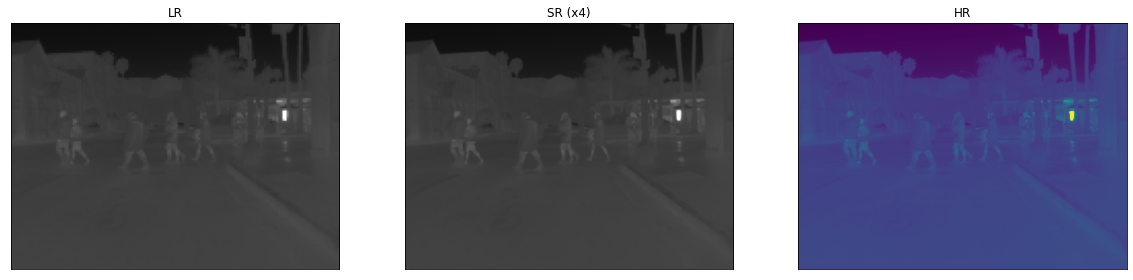

In [9]:
resolve_and_plot('demo/0004x4.png','demo/0004.png')

0.9652742711097178


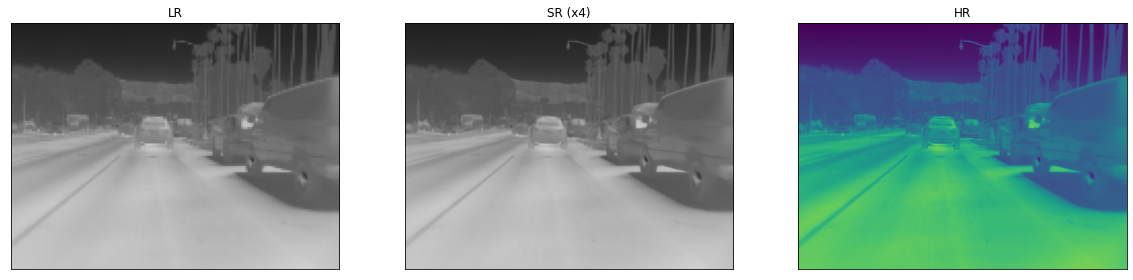

In [10]:
resolve_and_plot('demo/1064x4.png','demo/1064.png')

0.8940183288244273


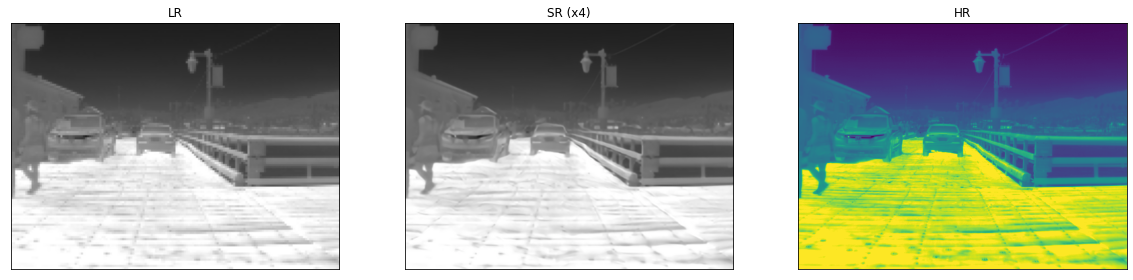

In [11]:
resolve_and_plot('demo/0303x4.png','demo/0303.png')